# **Moving Average Crossover Trading Strategy**
## A trading strategy with non-constant weights which adapts to the recent behavior of asset price behavior. 

In [194]:
import quandl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from functools import reduce

sns.set(style = 'darkgrid', context = 'talk', palette = 'Dark2')
%matplotlib inline

date_format = mdates.DateFormatter('%m/%y')

In [249]:
# Declare a beginning and end date for reading in data
start = "2015-01-01"
end =  "2019-12-31"

# Use Quandl API to import historic asset Closing Price data from start date to end date
df = quandl.get("WIKI/TSLA", start_date = start, end_date = end).Close
df2 = quandl.get("WIKI/JNJ", start_date = start, end_date = end).Close
df3 = quandl.get("WIKI/AAPL", start_date = start, end_date = end).Close

# Merge assets into singular dataframe using date as index
df = pd.merge(df, df2, left_index = True, right_index = True)
df = pd.merge(df, df3, left_index = True, right_index = True)

# Rename columns according to asset name
df.columns = ['TSLA', 'JNJ', 'AAPL']

In [250]:
# Take the rolling (moving) average for short term and long term windows (window length is user decision)
short_rolling = df.rolling(window = 20).mean()
long_rolling = df.rolling(window = 100).mean()

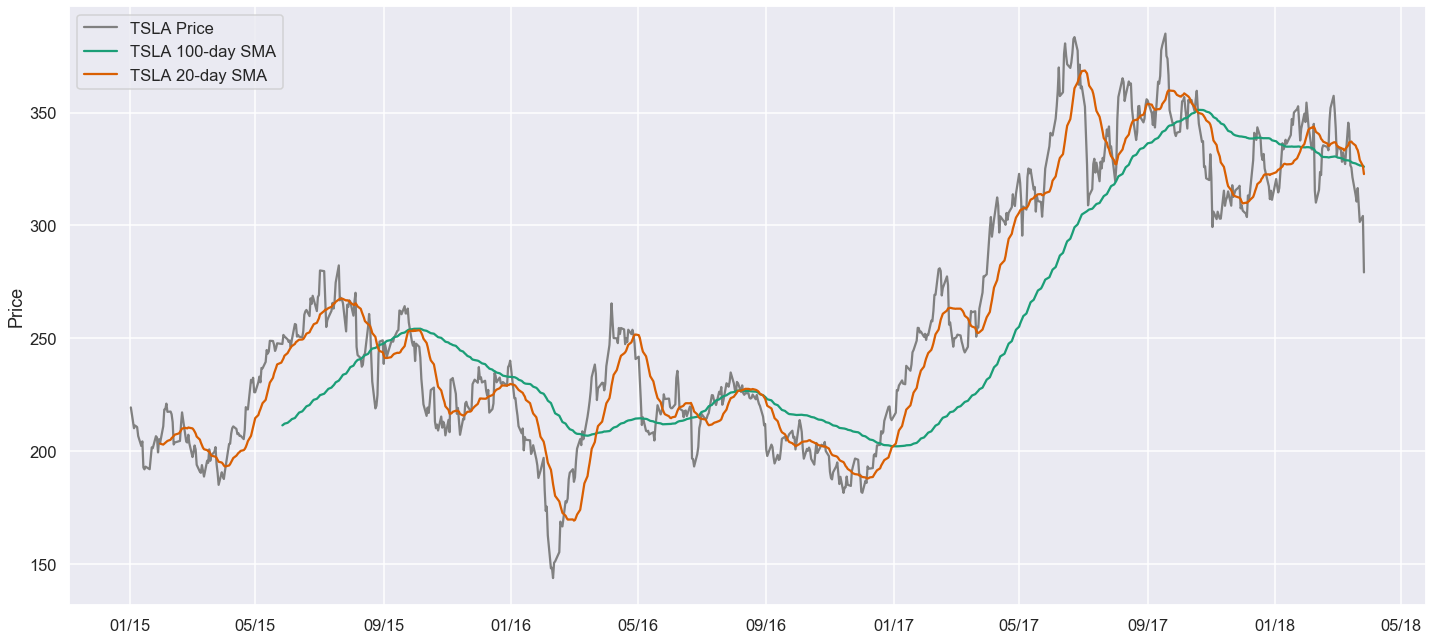

In [251]:
# Plot closing price, long rolling average, and short rolling average of individual asset using subplots
fig,ax = plt.subplots(figsize = (20,9))

ax.plot(df['TSLA'], label = 'TSLA Price', c = 'gray')
ax.plot(long_rolling['TSLA'], label = 'TSLA 100-day SMA')
ax.plot(short_rolling['TSLA'], label = 'TSLA 20-day SMA')

ax.legend(loc = 'upper left')
ax.set_ylabel('Price')
# Change x-axis to be "month/year" format using date_format variable previously established
ax.xaxis.set_major_formatter(date_format)

plt.tight_layout()

# Exponential Moving Average (No Pos. Size Provision)

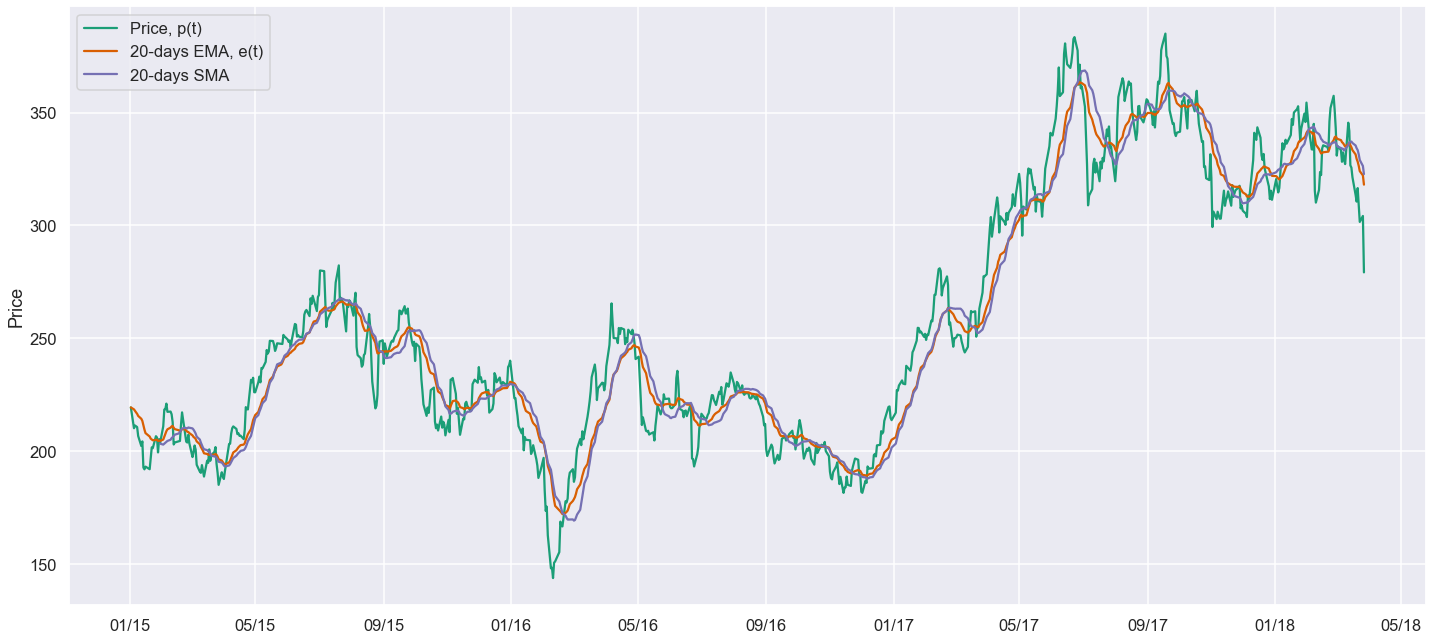

In [252]:
# Account for time-lag in rolling averages by creating an exponential moving average dataframe from our original 
# Setting the argument 'adjust = False' indicates that we are using a recursive calculation
ema_short = df.ewm(span = 20, adjust = False).mean()

# Plot exponential moving average time series along with the original price time series and the short rolling average time series
fig, ax = plt.subplots(figsize = (20,9))
ax.plot(df.TSLA, label = 'Price, p(t)')
ax.plot(ema_short.TSLA, label = '20-days EMA, e(t)')
ax.plot(short_rolling.TSLA, label = '20-days SMA')

ax.legend(loc = 'upper left')
ax.set_ylabel('Price')
ax.xaxis.set_major_formatter(date_format)

plt.tight_layout()

* When the price timeseries p(t) crosses the EMA timeseries e(t) from below, we will close any existing short position and go long (buy) one unit of the asset.
     - pi(t)>ei(t) , then wi(t)= 1/3
* When the price timeseries p(t) crosses the EMA timeseries e(t) from above, we will close any existing long position and go short (sell) one unit of the asset.
     -  pi(t)<ei(t), then wi(t)= -1/3

In [253]:
# Price differences between asset closing price and exponential MA series
trade_pos_raw = df - ema_short
trade_pos_raw.tail()

,TSLA,JNJ,AAPL
Date,,,
2018-03-21,-11.711853,-0.686201,-4.266867
2018-03-22,-17.318819,-4.067992,-6.054547
2018-03-23,-22.509408,-5.743421,-9.011018
2018-03-26,-17.977083,-3.124524,-1.068540
2018-03-27,-38.884028,-2.989807,-4.974870


In [254]:
# Take the sign of the trade position difference (1 if x > 0; -1 if x < 0 ) and multiply by the fixed weight of assets (1/3 due to three assets)
trade_positions = trade_pos_raw.apply(np.sign) * 1/3
trade_positions.tail()

,TSLA,JNJ,AAPL
Date,,,
2018-03-21,-0.333333,-0.333333,-0.333333
2018-03-22,-0.333333,-0.333333,-0.333333
2018-03-23,-0.333333,-0.333333,-0.333333
2018-03-26,-0.333333,-0.333333,-0.333333
2018-03-27,-0.333333,-0.333333,-0.333333


In [255]:
# Lag trading signals by a day (we are assuming that we traded at close of day t0 so we will have a long position on day t0+1)
trading_pos_final = trade_positions.shift(1)

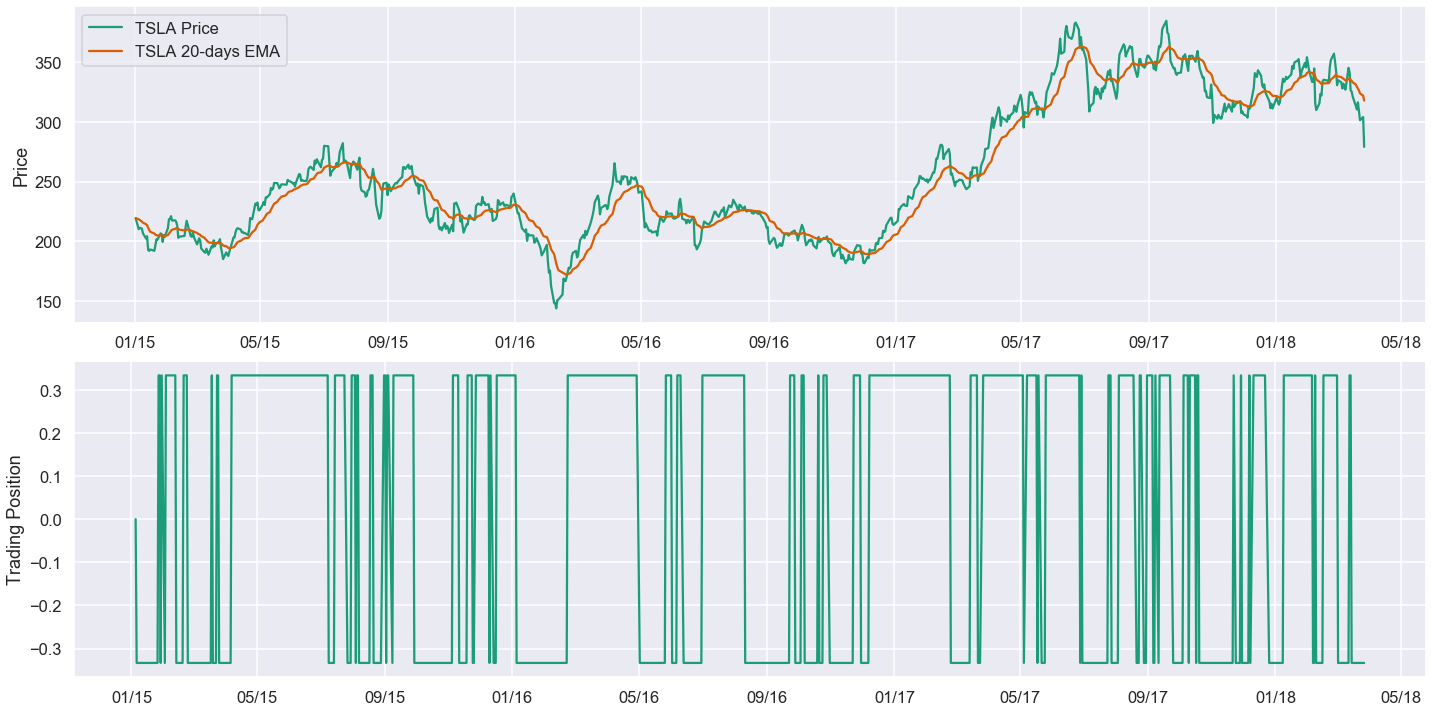

In [256]:
# Plot timeseries and respective trading position for an asset in the portfolio
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 10))

ax1.plot(df.TSLA, label = 'TSLA Price')
ax1.plot(ema_short.TSLA, label = 'TSLA 20-days EMA')

ax1.set_ylabel('Price')
ax1.legend(loc = 'upper left')
ax1.xaxis.set_major_formatter(date_format)

ax2.plot(trading_pos_final.TSLA, label = 'TSLA Trade Position')
ax2.set_ylabel('Trading Position')
ax2.xaxis.set_major_formatter(date_format)

plt.tight_layout()

# Strategy Performance

In [257]:
# Take log of prices and then the difference of consecutive log observations
asset_log_returns = np.log(df).diff()
asset_log_returns.head()

,TSLA,JNJ,AAPL
Date,,,
2015-01-02,NaN,NaN,NaN
2015-01-05,-0.042950,-0.007009,-0.028576
2015-01-06,0.005648,-0.004926,0.000094
2015-01-07,-0.001563,0.021836,0.013925
2015-01-08,-0.001589,0.007832,0.037703


In [258]:
# Multiply strategy positions with asset log returns
asset_log_returns = trading_pos_final * asset_log_returns
asset_log_returns.tail()

,TSLA,JNJ,AAPL
Date,,,
2018-03-21,-0.006358,0.000051,0.007638
2018-03-22,0.007918,0.009824,0.004753
2018-03-23,0.008254,0.006020,0.007800
2018-03-26,-0.002906,-0.006047,-0.015460
2018-03-27,0.028588,0.000471,0.008658


In [259]:
# Get cumulative log-returns per asset
cumul_asset_log_returns = asset_log_returns.cumsum()
# Transform to erlative returns
cumul_asset_relative_returns = np.exp(cumul_asset_log_returns) - 1

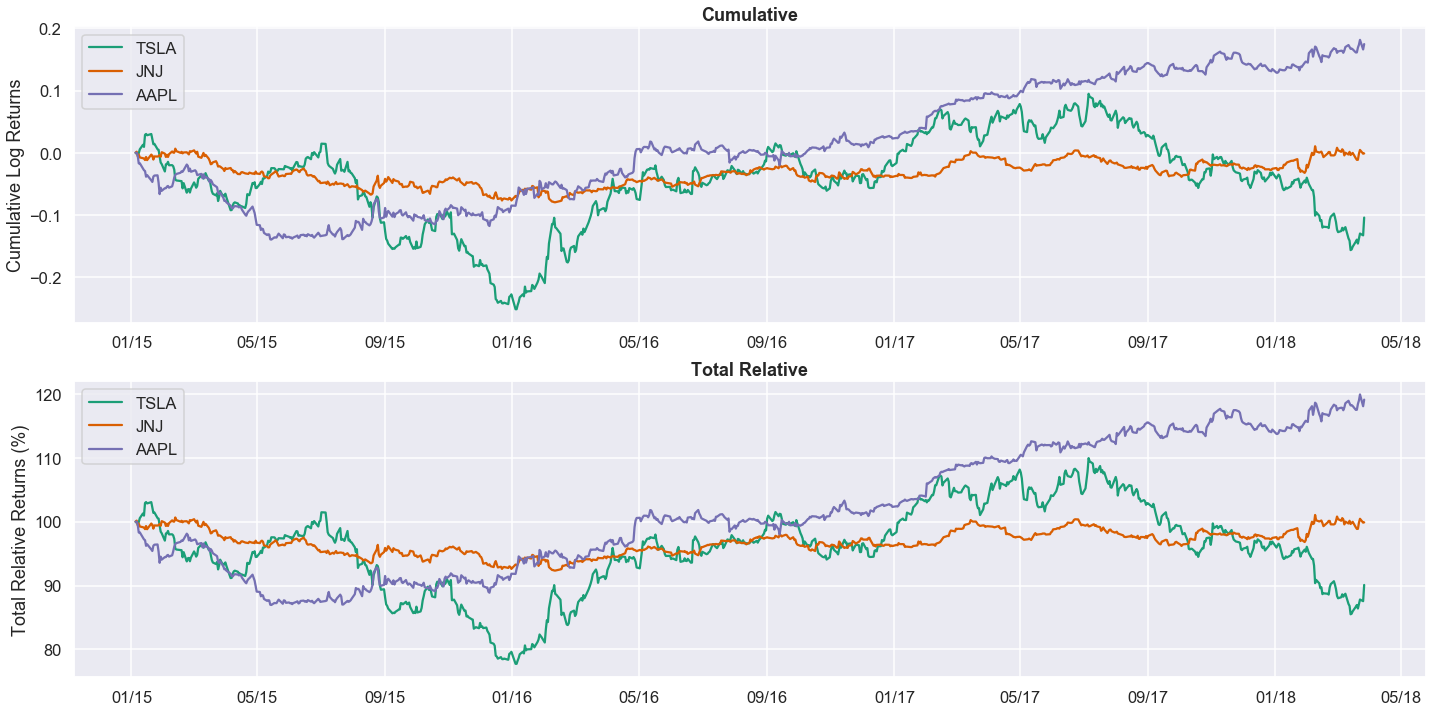

In [260]:
# Plot the cumulative log returns of asset portfolio in addition to plotting the total relative return
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 10))

for c in asset_log_returns:
    ax1.plot(cumul_log_returns.index, cumul_log_returns[c], label = str(c))
    
ax1.set_ylabel('Cumulative Log Returns')
ax1.legend(loc = 'best')
ax1.xaxis.set_major_formatter(date_format)
ax1.set_title('Cumulative', fontweight = 'bold')

for c in asset_log_returns:
    ax2.plot(cumul_relative_returns.index, 100*cumul_relative_returns[c], label = str(c))
    
ax2.set_ylabel('Total Relative Returns (%)')
ax2.legend(loc = 'best')
ax2.xaxis.set_major_formatter(date_format)
ax2.set_title('Total Relative', fontweight = 'bold')

plt.tight_layout()

# Total Strategy Return

In [261]:
# Total strategy relative returns 
cumul_relative_return_exact = cumul_asset_relative_returns.sum(axis = 1)
# Cumulative log-returns per asset
cumul_log_return = cumul_asset_log_returns.sum(axis = 1)
# Turn cumulative log returns to approximate relative returns
cumul_relative_return_appx = np.exp(cumul_log_return) - 1

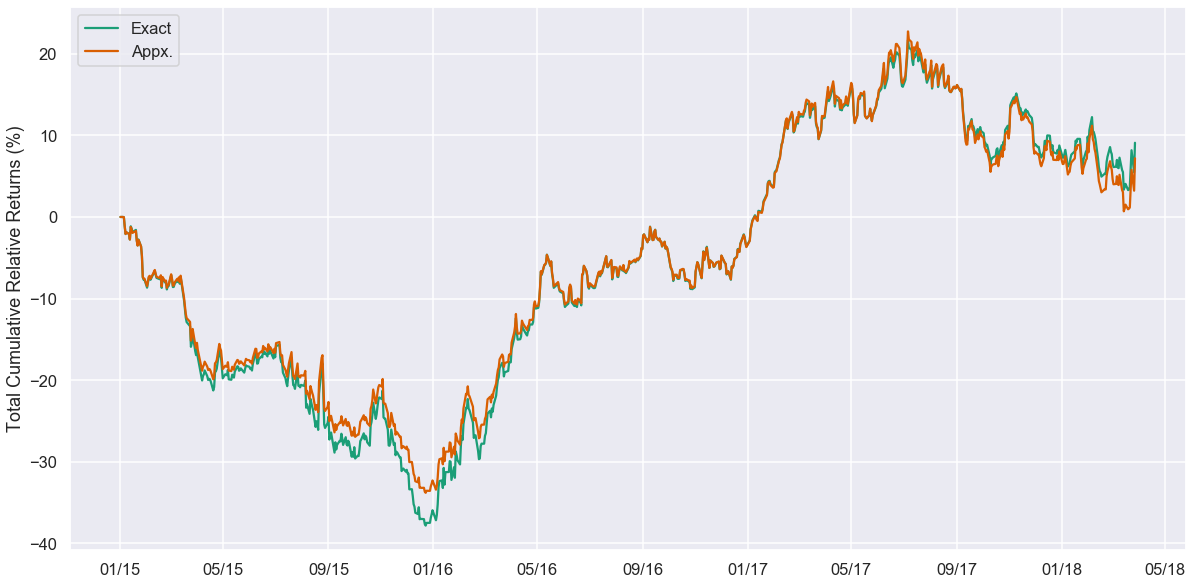

In [262]:
# Plot Exact and Approximate equity curves
fig, ax = plt.subplots(figsize = (20, 10))
ax.plot(cumul_relative_return_exact.index, 100*cumul_relative_return_exact, label = 'Exact')
ax.plot(cumul_relative_return_appx.index, 100*cumul_relative_return_appx, label = 'Appx.')

ax.set_ylabel('Total Cumulative Relative Returns (%)')
ax.legend(loc = 'upper left')
ax.xaxis.set_major_formatter(date_format)

In [263]:
# Define a function to print lifetime total portfolio returns and average yearly returns
def print_yearly_statistics(portfolio_cumulative_relative_returns, days_per_year = 52*5):
    total_days_in_sim = portfolio_cumulative_relative_returns.shape[0]
    number_of_years = total_days_in_sim/days_per_year
    
    # Take final data point as the most recent total return to portfolio
    total_portfolio_return = portfolio_cumulative_relative_returns[-1]
    # Average portfolio return with compound return assumption
    average_yearly_return = (1 + total_portfolio_return)**(1/number_of_years) - 1
    
    print('Total portfolio return is: ' + '{:5.2f}'.format(100*total_portfolio_return)+'%')
    print('Average yearly return is: ' + '{:5.2f}'.format(100*average_yearly_return) + '%')
    

In [264]:
print_yearly_statistics(cumul_relative_return_exact)

Total portfolio return is:  9.09%
Average yearly return is:  2.83%


# Strategy Comparison with Simply Buy-and-Hold Strategy

In [265]:
# Instantaite a new DF withvaflues = 1/3 to represent tertiary weight of portfolio
simple_weights_matrix = pd.DataFrame(1/3, index = df.index, columns = df.columns)
# Simple strategy log returns 
simple_strategy_asset_log_returns = simple_weights_matrix * asset_log_returns
# Cumulative log-returns per asset
simple_cum_strategy_asset_log_returns = simple_strategy_asset_log_returns.cumsum()
# Transform cumulative log returns to relative returns
simple_cum_strategy_asset_relative_returns = np.exp(simple_cum_strategy_asset_log_returns) - 1
# Total relative returns for simple strategy
simple_cum_relative_return_exact = simple_cum_strategy_asset_relative_returns.sum(axis = 1)

Total portfolio return is:  2.55%
Average yearly return is:  0.81%


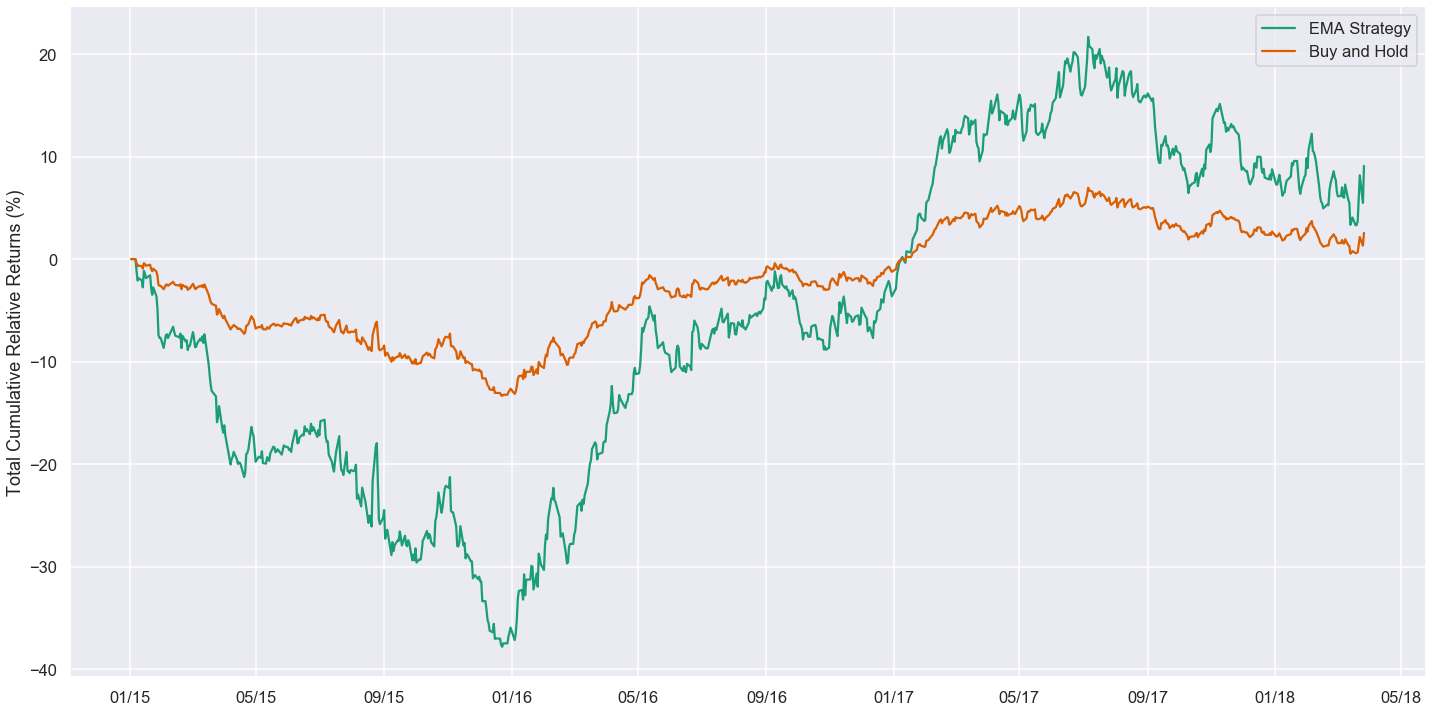

In [266]:
# Plot exponential moving average crossover strategy against simple buy and hold strategy
fig, ax = plt.subplots(figsize = (20, 10))

ax.plot(cumul_relative_return_exact.index, 100*cumul_relative_return_exact, label = 'EMA Strategy')
ax.plot(simple_cum_relative_return_exact.index, 100*simple_cum_relative_return_exact, label = 'Buy and Hold')

ax.set_ylabel('Total Cumulative Relative Returns (%)')
ax.legend(loc = 'best')
ax.xaxis.set_major_formatter(date_format)
plt.tight_layout()

print_yearly_statistics(simple_cum_relative_return_exact)